In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
print(project_root)
if project_root not in sys.path:
    sys.path.append(project_root)

c:\Users\Camille\Documents\TWR


In [2]:
from training_models.config.database import AsyncSessionLocal
from training_models.repositories.campaigns_repository import CampaignRepository
from training_models.repositories.request_repository import RequestsRepository
from training_models.config.mongo import mongo_collection, mongo_client

campaign_repository = CampaignRepository(session_factory=AsyncSessionLocal)
mongo_request_repository = RequestsRepository(collection=mongo_collection)

c:\Users\Camille\Documents\TWR\mil\.venv\Lib\site-packages\motor\core.py:171: UserWarning: You appear to be connected to a DocumentDB cluster. For more information regarding feature compatibility and support please visit https://www.mongodb.com/supportability/documentdb
  delegate = self.__delegate_class__(*args, **kwargs)


Garantindo índices...


In [3]:
# 3. Configuração
import torch
from attention_based import MILTrainingService

c:\Users\Camille\Documents\TWR\mil\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using 11 out of 12 cores


In [4]:
# traffic_source_alvo = "tiktok" # Altere para a fonte real

# training_service = MILTrainingService(
#     traffic_source=traffic_source_alvo,
#     repo_requests=mongo_request_repository,
#     repo_campaigns=campaign_repository,
#     device="cuda" if torch.cuda.is_available() else "cpu",
#     emb_config="fasttext",
#     bag_size=3
# )

# # 4. Execução Direta (A mágica do Jupyter)
# try:
#     print(f"Iniciando pipeline para a fonte: {traffic_source_alvo}")
    
#     # É só usar o await direto na célula!
#     await training_service.training_pipeline(
#         epochs=15, 
#         path="models"
#     )
    
# except Exception as e:
#     print(f"Ocorreu um erro durante o pipeline: {e}")
    
# finally:
#     # Fecha as conexões com o banco de dados
#     print("Limpando conexões com o banco de dados...")


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def plot_attention_for_bot_ips(modelo, dataloader, device, num_ips_to_plot=3):
    """
    Procura por IPs que o modelo classificou corretamente como Bots (Verdadeiros Positivos)
    e plota o peso de atenção que cada requisição HTTP daquele IP recebeu.
    """
    modelo.eval()
    ips_plotados = 0
    
    with torch.no_grad():
        for i, (bag, label) in enumerate(dataloader):
            bag = bag.to(device)
            label = label.to(device)
            
            # Pula os humanos (queremos ver como ele caça os bots)
            if label.item() == 0.0:
                continue
                
            # Faz a previsão
            pred, attention = modelo(bag)
            
            # Se o modelo acertou que é um bot (Verdadeiro Positivo)
            if pred.item() > 0.5:
                # Extrai os pesos (remove dimensões extras do batch=1)
                pesos = attention.squeeze().cpu().numpy()
                
                # Se o IP tiver apenas 1 requisição, o numpy pode retornar um float em vez de array.
                # Garantimos que seja um array para o plot.
                if pesos.ndim == 0:
                    pesos = np.array([pesos])
                
                num_requisicoes = len(pesos)
                
                # Prepara o gráfico
                plt.figure(figsize=(10, 4))
                
                # Destaca em vermelho a requisição com maior peso (o "gatilho" do bot)
                cores = ['red' if peso == max(pesos) else 'skyblue' for peso in pesos]
                
                plt.bar(range(num_requisicoes), pesos, color=cores, edgecolor='black')
                
                # Configurações visuais
                plt.title(f"Auditoria de IP Malicioso #{ips_plotados + 1}\nPrevisão do Modelo: {pred.item():.4f} (1.0 = Certeza Absoluta de Bot)", fontsize=12)
                plt.xlabel("Índice da Requisição HTTP na Sessão", fontsize=10)
                plt.ylabel("Peso de Atenção (Culpa)", fontsize=10)
                plt.xticks(range(num_requisicoes))
                plt.ylim(0, 1.05) # Atenção vai de 0 a 1
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                
                plt.tight_layout()
                plt.show()
                
                ips_plotados += 1
                
                if ips_plotados >= num_ips_to_plot:
                    break

# Como chamar a função no seu Notebook:

In [6]:
hashes = ["0h5ff0hx9e", "3zdba5h0e9", "9ct9zcf7xe", 'eoqs2p9hvl', "gp0cj2b193", "mdwcdjlo0h"]

In [7]:
import pandas as pd

results, hashes_info = await mongo_request_repository.get_training_sample_by_hashes(
      hashes=hashes, 
      limit_each=500,
      rule_id=True
)
df = pd.DataFrame(results)

[{'_id': 'mdwcdjlo0h', 'start_datetime': datetime.datetime(2026, 2, 17, 22, 56, 54, 227000), 'end_datetime': datetime.datetime(2026, 2, 24, 22, 16, 43, 54000)}, {'_id': '9ct9zcf7xe', 'start_datetime': datetime.datetime(2026, 2, 18, 0, 32, 44, 937000), 'end_datetime': datetime.datetime(2026, 2, 21, 0, 27, 53, 572000)}, {'_id': 'eoqs2p9hvl', 'start_datetime': datetime.datetime(2026, 2, 17, 23, 32, 5, 138000), 'end_datetime': datetime.datetime(2026, 2, 20, 12, 3, 27, 133000)}, {'_id': '0h5ff0hx9e', 'start_datetime': datetime.datetime(2026, 2, 17, 22, 35, 49, 951000), 'end_datetime': datetime.datetime(2026, 2, 24, 22, 36, 13, 53000)}, {'_id': 'gp0cj2b193', 'start_datetime': datetime.datetime(2026, 2, 17, 22, 35, 57, 930000), 'end_datetime': datetime.datetime(2026, 2, 24, 20, 34, 17, 613000)}]


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_with_ip(modelo, dataloader, device, num_ips_to_plot=3):
    modelo.eval()
    ips_plotados = 0
    
    print("Iniciando auditoria visual. Procurando bots...")
    
    with torch.no_grad():
        # ATENÇÃO AQUI: Agora recebemos 3 variáveis do DataLoader
        for bag, label, ip_tuple in dataloader:
            bag = bag.to(device)
            label = label.to(device)
            
            # Como batch_size=1, o IP vem como uma tupla de 1 elemento. Extraímos a string:
            ip_string = ip_tuple[0] 
            
            # Pula IPs normais (humanos), queremos ver como ele caça os bots
            if label.item() == 0.0:
                continue
                
            # Faz a previsão
            pred, attention = modelo(bag)
            
            # Se o modelo cravou que é um bot (Certeza > 85%)
            if pred.item() > 0.85:
                pesos = attention.squeeze().cpu().numpy()
                
                # Tratamento para IPs que fizeram apenas 1 requisição
                if pesos.ndim == 0:
                    pesos = np.array([pesos])
                
                num_requisicoes = len(pesos)
                
                # Prepara o gráfico
                plt.figure(figsize=(10, 4))
                
                # Destaca em vermelho o request que o modelo achou mais culpado
                cores = ['red' if peso == max(pesos) else 'skyblue' for peso in pesos]
                plt.bar(range(num_requisicoes), pesos, color=cores, edgecolor='black')
                
                # O IP AGORA APARECE NO TÍTULO!
                plt.title(f"Auditoria do IP Malicioso: {ip_string}\nCerteza do Modelo: {pred.item()*100:.2f}% | Total de Reqs: {num_requisicoes}", fontsize=12, fontweight='bold')
                plt.xlabel("Índice da Requisição HTTP na Sessão", fontsize=10)
                plt.ylabel("Atenção (Culpa)", fontsize=10)
                plt.xticks(range(num_requisicoes))
                plt.ylim(0, 1.05)
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                
                plt.tight_layout()
                plt.show()
                
                ips_plotados += 1
                if ips_plotados >= num_ips_to_plot:
                    break

In [9]:
from asyncio.log import logger
from attention_based import MILBagDatasetLogical
from torch.utils.data import DataLoader
from data.embedding_service import EmbeddingService

df["decision"] = df["decision"].str.lower().replace({"bot": "bots"})

mapeamento_mil = {"bots": 1, "unsafe": 0}
df["decision_mil"] = df["decision"].map(mapeamento_mil)

PATH = "G:/Meu Drive/TWR/data"
LABEL_MAP = {"bot": 0, "unsafe": 1, "bots": 0}
conf = "fasttext"
traffic_source = 'tiktok'
model_path_ft = f"{PATH}/{traffic_source}/fasttext_{traffic_source}.model"  
# model_path_ft = "all-MiniLM-L6-v2"

try:
      EmbeddingService.get_instance(conf, model_path_ft, traffic_source=traffic_source)
except FileNotFoundError:
      print(f"Error: Embedding model not found at {model_path_ft}")

embeddings_matrix, texts = EmbeddingService.process_and_encode(df)

embeddings_matrix, texts = EmbeddingService.process_and_encode(df)

df["embedding"] = list(embeddings_matrix)

logger.info(f"Agrupando {len(df)} requisições por IPs únicos...")

bags_df = df.groupby("ip").agg({
      "embedding": list,       # Junta todos os vetores desse IP numa lista
      "decision_mil": list     # Junta todas as labels desse IP numa lista
}).reset_index()

# Define a label da Bag: Se o IP fez pelo menos 1 requisição maliciosa (1), a Bag vira 1.
bags_df["bag_label"] = bags_df["decision_mil"].apply(lambda labels: 1.0 if 1 in labels else 0.0)

dataset_test = MILBagDatasetLogical(bags_df)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

Fastext model path:  G:/Meu Drive/TWR/data/tiktok/fasttext_tiktok.model
[DEBUG] Model Path FASTTEXT: G:/Meu Drive/TWR/data/tiktok/fasttext_tiktok.model
2026-02-24 19:36:22,197 - INFO - loading FastText object from G:/Meu Drive/TWR/data/tiktok/fasttext_tiktok.model


2026-02-24 19:36:22,327 - INFO - loading wv recursively from G:/Meu Drive/TWR/data/tiktok/fasttext_tiktok.model.wv.* with mmap=None
2026-02-24 19:36:22,328 - INFO - loading vectors_vocab from G:/Meu Drive/TWR/data/tiktok/fasttext_tiktok.model.wv.vectors_vocab.npy with mmap=None
2026-02-24 19:36:22,634 - INFO - loading vectors_ngrams from G:/Meu Drive/TWR/data/tiktok/fasttext_tiktok.model.wv.vectors_ngrams.npy with mmap=None
2026-02-24 19:36:34,167 - INFO - setting ignored attribute vectors to None
2026-02-24 19:36:34,168 - INFO - setting ignored attribute buckets_word to None
2026-02-24 19:36:52,131 - INFO - loading syn1neg from G:/Meu Drive/TWR/data/tiktok/fasttext_tiktok.model.syn1neg.npy with mmap=None
2026-02-24 19:36:52,486 - INFO - setting ignored attribute cum_table to None
2026-02-24 19:36:52,943 - INFO - FastText lifecycle event {'fname': 'G:/Meu Drive/TWR/data/tiktok/fasttext_tiktok.model', 'datetime': '2026-02-24T19:36:52.943639', 'gensim': '4.4.0', 'python': '3.11.9 (tags/v

Criando Vocabulário: 100%|██████████| 1000/1000 [00:01<00:00, 797.76it/s]


Using 11 out of 12 cores


Vetorizando: 100%|██████████| 1000/1000 [00:14<00:00, 68.43it/s]


Finishing encoding
Enter to Fasttext encoder


Criando Vocabulário: 100%|██████████| 1000/1000 [00:01<00:00, 905.42it/s]


Using 11 out of 12 cores


Vetorizando: 100%|██████████| 1000/1000 [00:13<00:00, 71.83it/s]

Finishing encoding
2026-02-24 19:37:23,895 - INFO - Agrupando 1000 requisições por IPs únicos...



c:\Users\Camille\Documents\TWR\mil\attention_based.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  bag_tensor = torch.tensor(row["embedding"], dtype=torch.float32)


In [10]:
from attention_based import AttentionMIL


# Mude isto:
# modelo = AttentionMIL(in_features=300)

# Para isto (verifique o nome exato do parâmetro na sua classe):
modelo = AttentionMIL(in_features=300, hidden_dim=256)
# 1. Carrega o arquivo completo
checkpoint = torch.load("models/tiktok/fasttext/attention_mil.pth", weights_only=False)

# 2. EXTRAI APENAS OS PESOS (É esta linha que resolve o erro!)
pesos = checkpoint["model_state_dict"]

# 3. Passa a variável 'pesos' (e não o 'checkpoint') para o modelo
modelo.load_state_dict(pesos)

modelo.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Iniciando auditoria visual. Procurando bots...


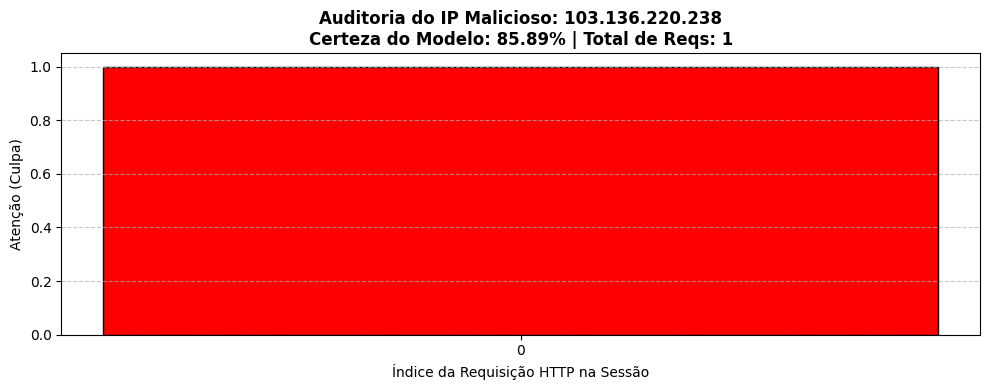

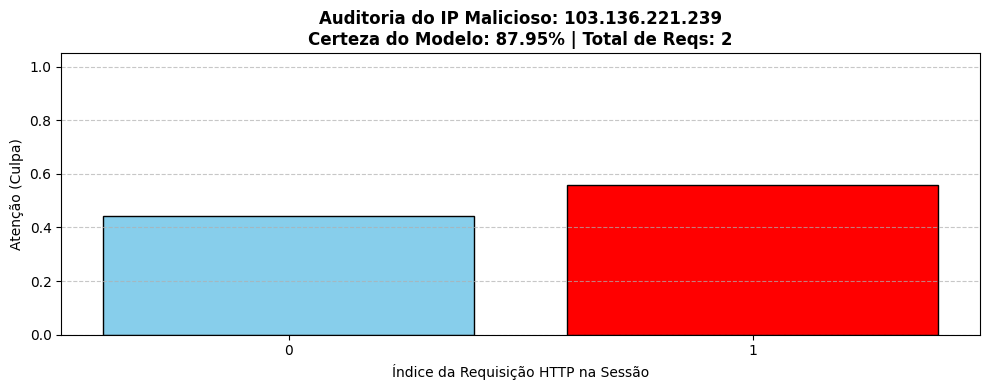

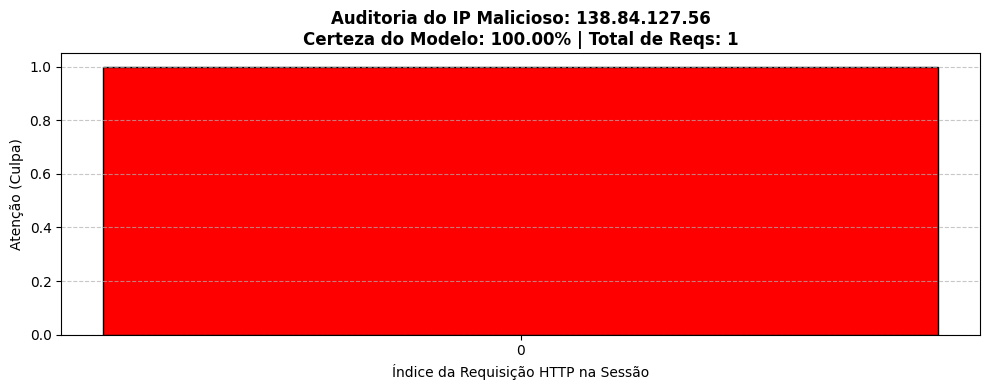

In [11]:
plot_attention_with_ip(modelo, dataloader=test_loader, device=device)